In [285]:
import os
import io

import ee
import geemap.core as geemap

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib

from urllib.request import urlopen, Request
from PIL import Image

import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from skimage.transform import resize
from skimage.io import imread
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import random

### Classifying imagery with Google Earth Engine
Use Google Earth Engine datasets and provided library for classification: https://developers.google.com/earth-engine/guides/machine-learning

In [286]:
ee.Authenticate()
ee.Initialize(project = 'ee-nikolaydragomirovzhechev')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


## Supervised Classification 

#### Land Cover Mapping  
Categorize areas into land cover types like urban, forest, or water.  


Enables monitoring of land cover changes over time with land cover classification using CART (Classification and Regression Tree) in Earth Engine.  
Data:  
- Collect images from Landsat 8 (LANDSAT/LC08/C02/T1_L2).
- Scale and mask each image.
- Creates a cloud-free composite by taking the median value for each pixel across all images


Preprocess:
- Remove unwanted pixels.
- Select visible, near-infrared (NIR), shortwave-infrared (SWIR), and thermal bands as input features for the classification model.
- Scale and offset.
- Apply mask.


Training:  
- Uses a predefined FeatureCollection (demo_landcover_labels) containing points with known land cover classes.  
- Each point has a landcover property that stores numeric labels (e.g., 0 = Urban, 1 = Forest, 2 = Water).


Classifier:  
- Uses a CART (Classification and Regression Tree) model. CART splits data based on decision rules to classify pixels into categories.  


Applies the trained classifier to the entire image, assigning each pixel a land cover class (e.g., 0 = Urban, 1 = Forest, 2 = Water).

Visualization:  
- Setp map coordinates to predefined ones.
- Add input image visualizing the cloud-free compoiste with specific bands (RGB bands).
- Displays the classified image with land cover classes:
    - Orange: Urban (class 0)
    - Green: Forest (class 1)
    - Blue: Water (class 2)

In [287]:
# Define a function that scales and masks Landsat 8 surface reflectance images.
def prep_l8_imgs(image):
    """
        Scales and masks Landsat 8 surface reflectance images.
        Args:
            image: the image to be processed.
    """
    
    # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
    qa_mask = image.select('QA_PIXEL').bitwiseAnd(0b11111).eq(0)
    saturation_mask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    def _get_factor_img(factor_names):
      factor_list = image.toDictionary().select(factor_names).values()
      return ee.Image.constant(factor_list)

    scale_img = _get_factor_img([
        'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
    offset_img = _get_factor_img([
        'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
    scaled = image.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

    # Replace original bands with scaled bands and apply masks.
    return image.addBands(scaled, None, True).updateMask(qa_mask).updateMask(saturation_mask)

Dataset:  
https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2

In [288]:
# Make a cloud-free Landsat 8 surface reflectance composite.
l8_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterDate('2021-03-01', '2021-07-01')
    .map(prep_l8_imgs)
    .median())

In [289]:
# show image object
# l8_image

In [290]:
# Use these bands for prediction.
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10']

# Load training points. The numeric property 'class' stores known labels.
points = ee.FeatureCollection('GOOGLE/EE/DEMOS/demo_landcover_labels')

# This property stores the land cover labels as consecutive
# integers starting from zero.
label = 'landcover'

# Overlay the points on the imagery to get training.
training = l8_image.select(bands).sampleRegions(
    collection=points, properties=[label], scale=30
)

Classification and Regression Trees (CART) is a decision tree algorithm that is used for both classification and regression tasks. It is a supervised learning algorithm that learns from labelled data to predict unseen data.

In [291]:
# Train a CART classifier with default parameters.
trained = ee.Classifier.smileCart().train(training, label, bands)

In [292]:
# Classify the image with the same bands used for training.
classified = l8_image.select(bands).classify(trained)
classified

In [293]:
# Display the inputs and the results.
m = geemap.Map()
m.set_center(-122.0877, 37.7880, 11)
m.add_layer(
    l8_image,
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'image',
)
m.add_layer(
    classified,
    {'min': 0, 'max': 2, 'palette': ['orange', 'green', 'blue']},
    'classification',
)
m

Map(center=[37.788, -122.0877], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

#### Identify areas of forest loss  
Processes Landsat 8 surface reflectance data to create a cloud-free composite, prepare training data, train a classifier, and then classify the image to identify areas of deforestation.

Represent forested and non-forested areas.  
FeatureCollection:
- Combines polygons into a dataset with a class property (1 for forest, 0 for non-forest).  
Classifier:  
- SVM classifier with a radial basis function (RBF) kernel.

  
Apply the trained classifier to the entire composite image, labeling each pixel as either forest (1) or non-forest (0).  
Displays the composite with bands SR_B4 (red), SR_B3 (green), and SR_B2 (blue), which are in the visible spectrum.

Classification Result:  
- Displays the classified map with colors:  
    - Orange: Non-forest (class 0)  
    - Green: Forest (class 1)  

In [294]:
# Define a function that scales and masks Landsat 8 surface reflectance images.
def prep_sr_l8(image):
  # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  qa_mask = image.select('QA_PIXEL').bitwiseAnd(0b11111).eq(0)
  saturation_mask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  def _get_factor_img(factor_names):
    factor_list = image.toDictionary().select(factor_names).values()
    return ee.Image.constant(factor_list)
  scale_img = _get_factor_img([
      'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
  offset_img = _get_factor_img([
      'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
  scaled = image.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

  # Replace original bands with scaled bands and apply masks.
  return image.addBands(scaled, None, True).updateMask(
      qa_mask).updateMask(saturation_mask)


# Make a cloud-free Landsat 8 surface reflectance composite.
l8_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterDate('2018-01-01', '2019-01-01')
    .map(prep_sr_l8)
    .median())

# Use these bands for prediction.
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']

# Manually created polygons.
forest1 = ee.Geometry.Rectangle(-63.0187, -9.3958, -62.9793, -9.3443)
forest2 = ee.Geometry.Rectangle(-62.8145, -9.206, -62.7688, -9.1735)
non_forest1 = ee.Geometry.Rectangle(-62.8161, -9.5001, -62.7921, -9.4486)
non_forest2 = ee.Geometry.Rectangle(-62.6788, -9.044, -62.6459, -8.9986)

# Make a FeatureCollection from the hand-made geometries.
polygons = ee.FeatureCollection([
    ee.Feature(non_forest1, {'class': 0}),
    ee.Feature(non_forest1, {'class': 0}),
    ee.Feature(forest1, {'class': 1}),
    ee.Feature(forest2, {'class': 1}),
])

# Get the values for all pixels in each polygon in the training.
training = l8_image.sampleRegions(
    # Get the sample from the polygons FeatureCollection.
    collection=polygons,
    # Keep this list of properties from the polygons.
    properties=['class'],
    # Set the scale to get Landsat pixels in the polygons.
    scale=30,
)

# Create an SVM classifier with custom parameters.
classifier = ee.Classifier.libsvm(kernelType='RBF', gamma=0.5, cost=10)

# Train the classifier.
trained = classifier.train(training, 'class', bands)

# Classify the image. forest (1) or non-forest (0)
classified = l8_image.classify(trained)

# Display the classification result and the input image.
m = geemap.Map()
m.set_center(-62.836, -9.2399, 9)
m.add_layer(
    l8_image,
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'image',
)
m.add_layer(polygons, {'color': 'yellow'}, 'training polygons')
m.add_layer(
    classified,
    {'min': 0, 'max': 1, 'palette': ['orange', 'green']},
    'deforestation',
)
m

Map(center=[-9.2399, -62.836], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

#### Land Cover Analysis  
Identify areas of forest, water, urban, etc. Detects land cover changes over time for environmental monitoring. a Using Random Forest (RF) classifier to train and validate a land cover classification model. 

- Define latitude and longitude.
- Retreive Landsat 8 Tier 1 Level 2 data for the defined ROI (region of interest).
- Load MODIS International Geosphere-Biosphere Programme (IGBP) land cover classification as labels for training (contains 17 land cover classes (e.g., Forest, Urban, Water).
- Select speicif bands SR_B2 (Blue) to SR_B7 (SWIR2) for anlysis.
- Take the median value for each pixel (median composite) to create cloud-free images.

Combine the input image bands and MODIS labels into a single dataset. Randomly samples 5,000 points across the ROI to create a FeatureCollection of training data. Where each point has:  
- Landsat band values (SR_B2 to SR_B7) as features.
- MODIS land cover label (LC_Type1) as the target.
- Split the data into training (70%) and validation (30%) sets.

Random Forest Classifier:  
- Algorithm: Constructs an ensemble of decision trees.
- Features: Reflectance values from bands SR_B2 to SR_B7.
- Target (classProperty): MODIS land cover label (LC_Type1).
- We use 10 tress in the forest for higher accuracy.
- Outputs a classified map where each pixel is assigned a land cover class (0–16).

Model evaluation:
- Confusion Matrix for training accuracy: Compares predicted vs. true labels.
- Validation Accuracy for validation accuracy: Summarizes true positives, false positives, etc.

Outputs classified land cover map.

In [295]:
# Define a region of interest.
roi = ee.Geometry.BBox(-122.93, 36.99, -121.20, 38.16)

# Define a function that scales and masks Landsat 8 surface reflectance images.
def prep_sr_l8(image):
  """Scales and masks Landsat 8 surface reflectance images."""
  # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  qa_mask = image.select('QA_PIXEL').bitwiseAnd(0b1111).eq(0)
  saturation_mask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  def _get_factor_img(factor_names):
    factor_list = image.toDictionary().select(factor_names).values()
    return ee.Image.constant(factor_list)

  scale_img = _get_factor_img([
      'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
  offset_img = _get_factor_img([
      'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
  scaled = image.select('SR_B.|ST_B10').multiply(scale_img).add(offset_img)

  # Replace original bands with scaled bands and apply masks.
  return image.addBands(scaled, None, True).updateMask(
      qa_mask).updateMask(saturation_mask)


# Make a cloud-free Landsat 8 surface reflectance composite.
input_image = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(roi)
    .filterDate('2020-03-01', '2020-07-01')
    .map(prep_sr_l8)
    .median()
    .setDefaultProjection('EPSG:4326', None, 30)
    .select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])
)

# Use MODIS land cover, IGBP classification, for training.
modis = ee.Image('MODIS/006/MCD12Q1/2020_01_01').select('LC_Type1')

# Sample the input imagery to get a FeatureCollection of training data.
sample = input_image.addBands(modis).sample(
    region=roi, numPixels=5000, seed=0, geometries=True, tileScale=16
)

# The randomColumn() method will add a column of uniform random
# numbers in a column named 'random' by default.
sample = sample.randomColumn()

# # Sample the input imagery to get a FeatureCollection of training data.
# training = input_image.addBands(modis).sample(
#     region=roi, numPixels=5000, seed=0
# )

split = 0.7  # Roughly 70% training, 30% testing.
training = sample.filter(ee.Filter.lt('random', split))
display('Training size:', training.size())
validation = sample.filter(ee.Filter.gte('random', split))

# Spatial join (avoids overfitting and ensures robust validation).
# Ensures spatial independence by removing training points too close (<1000m) to validation points.
dist_filter = ee.Filter.withinDistance(
    distance=1000, leftField='.geo', rightField='.geo', maxError=10
)

join = ee.Join.inverted()

# Apply the join.
training = join.apply(training, validation, dist_filter)
display('Training size after spatial filtering:', training.size())

# Make a Random Forest classifier and train it.
classifier = ee.Classifier.smileRandomForest(10).train(
    features=training,
    classProperty='LC_Type1',
    inputProperties=['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],
)

# Classify the input imagery.
classified = input_image.classify(classifier)

# Measures accuracy on the training data.
# Get a confusion matrix representing resubstitution accuracy.
train_accuracy = classifier.confusionMatrix()
display('Resubstitution error matrix:', train_accuracy)
display('Training overall accuracy:', train_accuracy.accuracy())

# Sample the input with a different random seed to get validation data.
validation = (
    input_image.addBands(modis)
    .sample(
        region=roi,
        numPixels=5000,
        seed=1,
        # Filter the result to get rid of any null pixels.
    )
    .filter(ee.Filter.notNull(input_image.bandNames()))
)

# Classifies the validation dataset and compares predictions against actual labels.
validated = validation.classify(classifier)

# Get a confusion matrix representing expected accuracy.
test_accuracy = validated.errorMatrix('LC_Type1', 'classification')
display('Validation error matrix:', test_accuracy)
display('Validation overall accuracy:', test_accuracy.accuracy())

# Define a palette for the IGBP classification.
igbp_palette = [
    'aec3d4',  # water
    '152106', '225129', '369b47', '30eb5b', '387242',  # forest
    '6a2325', 'c3aa69', 'b76031', 'd9903d', '91af40',  # shrub, grass
    '111149',  # wetlands
    'cdb33b',  # croplands
    'cc0013',  # urban
    '33280d',  # crop mosaic
    'd7cdcc',  # snow and ice
    'f7e084',  # barren
    '6f6f6f'   # tundra
]

# Display the input and the classification with geemap in a notebook.
m = geemap.Map()
m.center_object(roi, 10)
m.add_layer(
    input_image.clip(roi),
    {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.25},
    'landsat',
)
m.add_layer(
    classified.clip(roi),
    {'palette': igbp_palette, 'min': 0, 'max': 17},
    'classification',
)
m

'Training size:'

'Training size after spatial filtering:'

'Resubstitution error matrix:'

'Training overall accuracy:'

'Validation error matrix:'

'Validation overall accuracy:'

Map(center=[37.57451999977034, -122.06500000000011], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Using classifier smileGradientTreeBoost:  
    Training overall accuracy: 0.9108      Validation overall accuracy: 0.6517303460692139


#### Unsupervised Classification (Clustering)  

Clustering does not rely on labeled training data. Instead, it groups data points based on their inherent characteristics (spectral similarity). using K-means Clustering where the algorithm divides the data into k clusters by minimizing the variance within each cluster and maximizing the variance between clusters. Useful for identifying patterns or features such as vegetation zones, water bodies, or urban areas in remote sensing images without prior labels.  

Each pixel contains spectral information from the bands in the image.
K-means Clustering:
- Here we specify k=15 clusters.
- The algorithm minimizes intra-cluster variance, ensuring pixels in the same cluster are spectrally similar.
- The trained clusterer is applied to the entire image to assign each pixel to one of the 15 clusters.
- The output is a single-band image where each pixel’s value corresponds to its cluster ID (an integer between 0 and 14).
  
Training:
- The clusterer is trained using the sampled pixel data, allowing it to learn the spectral characteristics of the region.

The map shows 15 distinct clusters representing different spectral characteristics of the landscape. Result is not tied to specific land cover types but provides insight into natural groupings in the data.

In [296]:
# Define a region in which to generate a segmented map.
region = ee.Geometry.Rectangle(29.7, 30, 32.5, 31.7)

# Load a Landsat composite for input.
input = (
    ee.ImageCollection('LANDSAT/COMPOSITES/C02/T1_L2_32DAY')
    .filterDate('2001-05', '2001-06')
    .first()
    .clip(region)
)

# Display the sample region.
m = geemap.Map()
m.set_center(31.5, 31.0, 8)
m.add_layer(ee.Image().paint(region, 0, 2), {}, 'region')

# Make the training dataset.
training = input.sample(region=region, scale=30, numPixels=5000)

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaKMeans(15).train(training)

# Cluster the input using the trained clusterer.
result = input.cluster(clusterer)

# Display the clusters with random colors.
m.add_layer(result.randomVisualizer(), {}, 'clusters')
m

Map(center=[31.0, 31.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

Overall Accuracy for both training and validation sets.  
Confusion Matrices for both training and validation, to show class-specific accuracy.

In [297]:
# Accuracy values from Earth Engine and convert to variables.
train_accuracy_value = train_accuracy.accuracy().getInfo()
test_accuracy_value = test_accuracy.accuracy().getInfo()

In [298]:
# Confusion matrix arrays from Earth Engine.
train_conf_matrix = train_accuracy.getInfo()
test_conf_matrix = test_accuracy.getInfo()

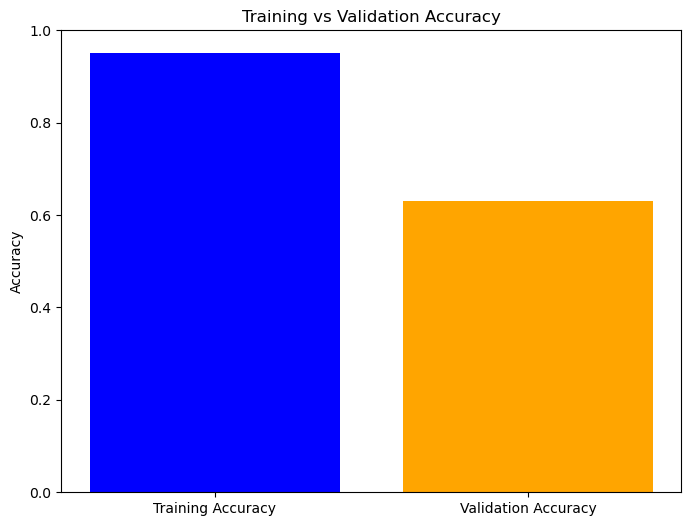

In [302]:
# Plot training and validation accuracy.
accuracies = [train_accuracy_value, test_accuracy_value]
labels = ['Training Accuracy', 'Validation Accuracy']

plt.figure(figsize=(8, 6))
plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

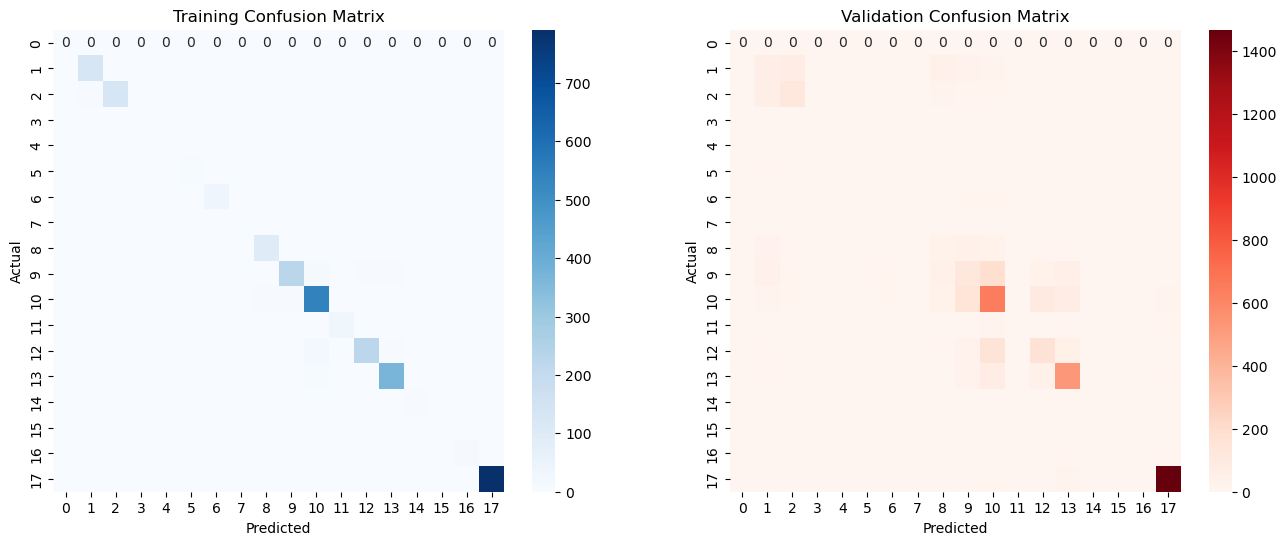

In [305]:
class_labels = [str(i) for i in range(len(train_conf_matrix))]  # Modify as per class count

# Create DataFrames for both matrices.
train_conf_df = pd.DataFrame(train_conf_matrix, index=class_labels, columns=class_labels)
test_conf_df = pd.DataFrame(test_conf_matrix, index=class_labels, columns=class_labels)

# Plot the confusion matrices.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(train_conf_df, annot=True, cmap='Blues', fmt='g', ax=axes[0])
axes[0].set_title('Training Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(test_conf_df, annot=True, cmap='Reds', fmt='g', ax=axes[1])
axes[1].set_title('Validation Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

### Classifying imagery with TensorFlow
Use TensorFlow API: https://www.tensorflow.org/tutorials/images/classification  
Dataset from Kaggle: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification?resource=downloadlips/

sattelite_images/  
&nbsp;    clody/  
&nbsp;    desert/  
&nbsp;    green_area/  
&nbsp;    water/  

In [263]:
dataset_path = pathlib.Path("Datasets/Classification_Tasks/data")

image_count = len(list(dataset_path.rglob('*.jpg')))
print(image_count)

5631


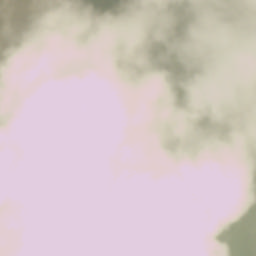

In [145]:
clody = list(dataset_path.glob('cloudy/*.jpg'))
PIL.Image.open(str(clody[0]))

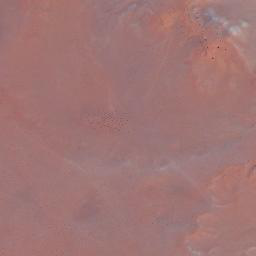

In [146]:
desert = list(dataset_path.glob('desert/*.jpg'))
PIL.Image.open(str(desert[0]))

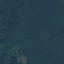

In [147]:
green_area = list(dataset_path.glob('green_area/*.jpg'))
PIL.Image.open(str(green_area[0]))

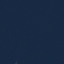

In [149]:
water = list(dataset_path.glob('water/*.jpg'))
PIL.Image.open(str(water[0]))

Create a dataset  
80% of the images for training and 20% for validation

In [150]:
batch_size = 32
img_height = 180
img_width = 180

In [214]:
# Load Dataset with TensorFlow
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
['cloudy', 'desert', 'green_area', 'water']


Visualize the data

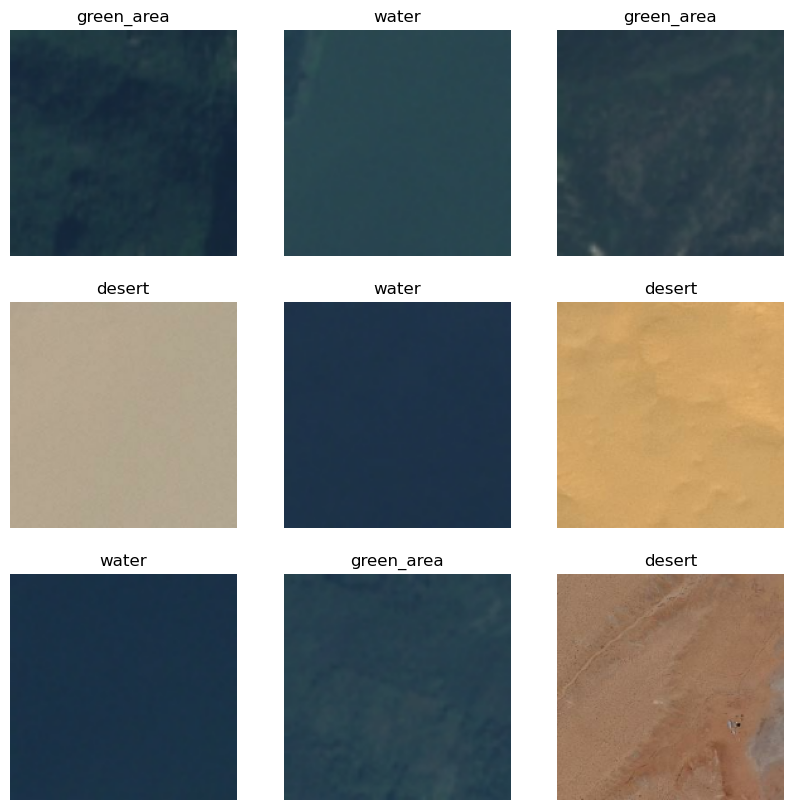

In [215]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [216]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


SVM example:

In [217]:
# --------
# Normalize and cache datasets
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_dataset(ds):
    return ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

train_ds = preprocess_dataset(train_ds)
val_ds = preprocess_dataset(val_ds)

# Extract features and labels for SVM
def extract_features_and_labels(dataset):
    features = []
    labels = []
    for images, lbls in dataset:
        features.extend(images.numpy())
        labels.extend(lbls.numpy())
    return np.array(features), np.array(labels)

x_train, y_train = extract_features_and_labels(train_ds)
x_val, y_val = extract_features_and_labels(val_ds)

# Flatten images for SVM
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)

# Dimensionality reduction with PCA
pca = PCA(n_components=50, random_state=77)
x_train_pca = pca.fit_transform(x_train_flat)
x_val_pca = pca.transform(x_val_flat)

# Train SVM with GridSearch
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.0001, 0.001, 0.1, 1], 'linear': ['rbf', 'poly']}
svc = svm.SVC(probability=True)
model = GridSearchCV(svc, param_grid)

model.fit(x_train_pca, y_train)
print("SVM Model Trained Successfully.")

# --------

SVM Model Trained Successfully.


In [264]:
categories = ['cloudy', 'desert', 'green_area', 'water']
flat_data_arr = [] #input array
target_arr = [] #output array
datadir = dataset_path

#path which contains all the categories of images
for i in categories:
    
    print(f'loading... category : {i}')
    path = os.path.join(datadir, i)
    count = 0
    
    for img in os.listdir(path):
        if count >= 10:  # limit number of images
            break
        
        img_array = imread(os.path.join(path,img))
        img_resized = resize(img_array,(150, 150 , 3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))

        count += 1
        
    print(f'loaded category:{i} successfully')
    
flat_data = np.array(flat_data_arr)
target = np.array(target_arr)
df = pd.DataFrame(flat_data) #dataframe
df['Target'] = target
x = df.iloc[:, :-1] #input data 
y = df.iloc[:, -1] #output data

loading... category : cloudy
loaded category:cloudy successfully
loading... category : desert
loaded category:desert successfully
loading... category : green_area
loaded category:green_area successfully
loading... category : water
loaded category:water successfully


In [218]:
# Evaluate the model [new]
y_pred = model.predict(x_val_pca)
print(classification_report(y_val, y_pred, target_names=categories))

              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       268
      desert       1.00      1.00      1.00       256
  green_area       0.88      0.93      0.91       305
       water       0.92      0.88      0.90       297

    accuracy                           0.95      1126
   macro avg       0.95      0.95      0.95      1126
weighted avg       0.95      0.95      0.95      1126



|               | precision      | recall     | f1-score      | support      |
| ------------- | ------------- | ------------- | ------------- | ------------- |
| cloudy | 1.00 | 1.00 | 1.00 | 268 |
| desert | 1.00 | 1.00 | 1.00 | 256 |
| green_area |  0.88 | 0.93 | 0.91 |305 |
| water | 0.92 | 0.88 | 0.90 | 297 |
| accuracy |   |   | 0.95 | 1126 |
| macro avg | 0.95  | 0.95 | 0.95 | 1126 |
| weighted avg | 0.95  | 0.95 | 0.95 | 1126 |

General info:  
Precision: This measures how many of the predicted positive labels were actually correct. High precision means that when the model predicts a class, it’s likely correct.

Your precision scores are very high for all categories, meaning the model does a great job of not making false positive errors.
Recall: This measures how many of the actual positive labels were correctly identified by the model. High recall means the model is good at identifying all the instances of a particular class.

The recall is also high for all categories, with a slight drop in the water category (88% recall). This suggests that the model might miss a few water images but still performs very well overall.
F1-Score: The harmonic mean of precision and recall, providing a balance between the two metrics. This is particularly useful when you want a balanced measure that doesn't favor precision over recall or vice versa.

The f1-scores are consistently high (mostly above 0.9), which indicates a good balance between precision and recall.
Support: This refers to the number of actual occurrences of each class in the dataset. The support values are roughly balanced, although green_area has slightly more instances than other classes.

Accuracy: The overall correctness of the model, calculated as the ratio of correctly predicted instances to total instances. The 95% accuracy is quite strong, especially in a multi-class classification task.

Macro Average: The average of the precision, recall, and f1-score across all categories, treating all categories equally. A macro average of 0.95 indicates that the model's performance is balanced across all classes.

Weighted Average: This average takes into account the support (number of instances) for each class. Since the classes are relatively balanced, the weighted average is similar to the macro average.

In [265]:
param_grid = {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
svc = svm.SVC(probability = True)
model = GridSearchCV(svc, param_grid)

In [266]:
model

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [267]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 77, stratify = y)
print('Splitted Successfully.')

model.fit(x_train, y_train)
print('The Model is Trained Succesfully.')

Splitted Successfully.
The Model is Trained Succesfully.


In [268]:
y_predict = model.predict(x_test)
print(f'Predicted Data is : {y_predict}')
print('Actual data is:')
print(y_test)
print(f'The model is { metrics.accuracy_score(y_predict, y_test) * 100 }% accurate.')

Predicted Data is : [0 0 3 1 2 3 2 1]
Actual data is:
7     0
4     0
36    3
15    1
24    2
31    3
25    2
17    1
Name: Target, dtype: int32
The model is 100.0% accurate.


Saved results from initial run are:
Predicted Data is : [2 3 0 1 1 0 2 1 2 1 3 2 3 3 3 2 2 1 3 3 0 3 0 0 0 1 2 0 3 1 1 1 2 0 3 0 2
 3 0 1]  
Actual data is:  
120    2  
185    3  
37     0  
54     1  
84     1  
23     0  
139    2  
85     1  
116    2  
94     1  
189    3  
125    2  
179    3  
178    3  
182    3  
118    2  
123    2  
82     1  
161    3  
192    3  
20     0  
184    3  
32     0  
31     0  
48     0  
57     1  
104    2  
39     0  
160    3  
75     1  
68     1  
74     1  
127    2  
43     0  
142    2  
47     0  
136    2  
180    3  
24     0  
59     1  
Name: Target, dtype: int32  
The model is 97.5% accurate.

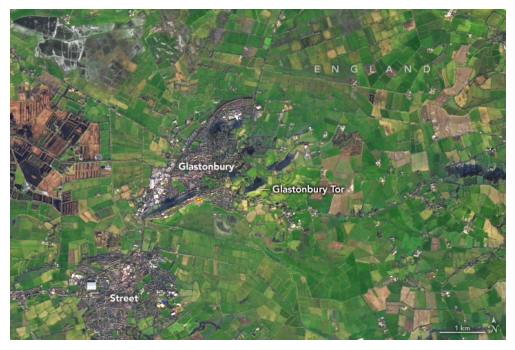

In [279]:
# Image examples
url_green = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/153000/153139/glastonbury_oli_20240119.jpg'
# url_desert = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/153000/153475/lakealgeria_oli2_20240812.jpg'
url_desert = 'https://services.meteored.com/img/article/agua-fosil-desierto-de-sahara-mas-de-10-000-anos-1705985338974_1024.jpg'
url_cloudy = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/78000/78562/spacific_tmo_2012180.jpg'
#url_water = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/145000/145610/capricorn_oli_2019244.jpg'
url_water = 'https://media.altphotos.com/cache/images/2017/03/04/04/x800/sea-ocean-water-texture.jpg'

# Read and plot an image
req = Request(url_green, headers = {'User-Agent': 'Mozilla/5.0'})
img_data = urlopen(req).read()
img = Image.open(io.BytesIO(img_data))

plt.imshow(img)
plt.axis('off')
plt.show()

# Ensure the image is in RGB mode
img = img.convert('RGB')
# Resize the image to 150x150
img_resize = img.resize((150, 150))
# Convert the resized image to a NumPy array
img_array = np.array(img_resized)
# img_array = img_array / 255.0
l = [img_array.flatten()]

probability = model.predict_proba(l)

In [281]:
# Debugging: Print input shape and values
print("Input shape:", np.array(l).shape)
print("Flattened input sample:", l[0][:10])  # Print first 10 elements for inspection

Input shape: (1, 67500)
Flattened input sample: [0.12156863 0.18823529 0.29803922 0.12156863 0.18823529 0.29803922
 0.12156863 0.18823529 0.29803922 0.12156863]


In [282]:
probability

array([[0.0392933 , 0.03463574, 0.19348234, 0.73258862]])

In [283]:
# Predict image
for ind, val in enumerate(Categories):
    print(f'{val} = { probability[0][ind] * 100 }%')
print('The predicted image is: '+Categories[model.predict(l)[0]])

cloudy = 3.92932994852334%
desert = 3.463574113654537%
green_area = 19.348234423247266%
water = 73.25886151457487%
The predicted image is: water


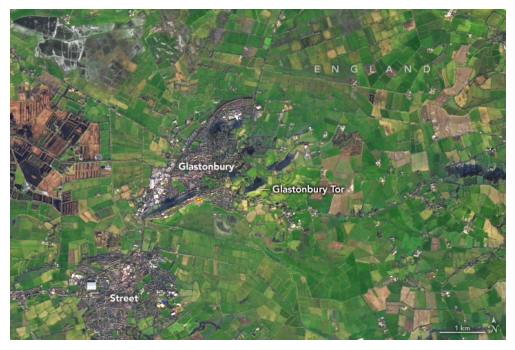

ValueError: X has 50 features, but SVC is expecting 67500 features as input.

In [274]:
# Image examples
url_green = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/153000/153139/glastonbury_oli_20240119.jpg'
# url_desert = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/153000/153475/lakealgeria_oli2_20240812.jpg'
url_desert = 'https://services.meteored.com/img/article/agua-fosil-desierto-de-sahara-mas-de-10-000-anos-1705985338974_1024.jpg'
url_cloudy = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/78000/78562/spacific_tmo_2012180.jpg'
#url_water = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/145000/145610/capricorn_oli_2019244.jpg'
url_water = 'https://media.altphotos.com/cache/images/2017/03/04/04/x800/sea-ocean-water-texture.jpg'

# Load the image from URL
req = Request(url_green, headers={'User-Agent': 'Mozilla/5.0'})
img_data = urlopen(req).read()
img = Image.open(io.BytesIO(img_data))

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Preprocess the image: Ensure RGB mode and resize to 180x180
img = img.convert('RGB')  # Convert to RGB mode
img_resize = img.resize((180, 180))  # Resize to match training dimensions

# Convert resized image to NumPy array and flatten
img_array = np.array(img_resize)
img_array_flattened = img_array.flatten().reshape(1, -1)  # Flatten and reshape for PCA

# Apply PCA to match training preprocessing
img_array_pca = pca.transform(img_array_flattened)  # Use the PCA instance from training

# Predict probabilities using the trained SVM model
probability = model.predict_proba(img_array_pca)

# Print probabilities for each category
for ind, val in enumerate(categories):
    print(f'{val} = {probability[0][ind] * 100:.2f}%')

# Predict the category of the image
predicted_index = model.predict(img_array_pca)[0]
print(f'The predicted image is: {categories[predicted_index]}')

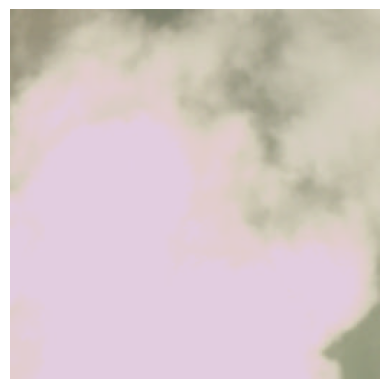

ValueError: X has 50 features, but SVC is expecting 67500 features as input.

In [269]:
# Access the first image in the a category
cloudy = list(dataset_path.glob('cloudy/*.jpg'))
img = Image.open(str(cloudy[0]))

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Preprocess the image: Ensure RGB mode and resize to 180x180
img = img.convert('RGB')  # Convert to RGB mode if not already
img_resize = img.resize((180, 180))  # Resize to match training dimensions

# Convert resized image to NumPy array and flatten
img_array = np.array(img_resize)
img_array_flattened = img_array.flatten().reshape(1, -1)  # Flatten and reshape for PCA

# Apply PCA to match training preprocessing
img_array_pca = pca.transform(img_array_flattened)  # Use the PCA instance from training

# Predict probabilities using the trained SVM model
probability = model.predict_proba(img_array_pca)

# Print probabilities for each category
for ind, val in enumerate(categories):
    print(f'{val} = {probability[0][ind] * 100:.2f}%')

# Predict the category of the image
predicted_index = model.predict(img_array_pca)[0]
print(f'The predicted image is: {categories[predicted_index]}')